In [1]:
%load_ext autoreload
%autoreload 2
from animalclef.spark import get_spark
from pyspark.sql import functions as F

spark = get_spark(cores=4, memory="10g")
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/12 02:27:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/12 02:27:25 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [6]:
from pathlib import Path

metadata = spark.read.parquet(f"{Path.home()}/shared/animalclef/data/parquet/metadata")
embeddings = spark.read.parquet(
    f"{Path.home()}/shared/animalclef/data/embeddings/dinov2"
)
df = metadata.join(embeddings, on="image_id").cache()
df.printSchema()

root
 |-- image_id: integer (nullable = true)
 |-- identity: string (nullable = true)
 |-- path: string (nullable = true)
 |-- date: date (nullable = true)
 |-- orientation: string (nullable = true)
 |-- species: string (nullable = true)
 |-- split: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- token: struct (nullable = true)
 |    |-- cls: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |    |-- avg_patch: array (nullable = true)
 |    |    |-- element: float (containsNull = true)



In [8]:
df.show(n=1, vertical=True, truncate=100)

-RECORD 0-----------------------------------------------------------------------------------------------------------
 image_id    | 11054                                                                                                
 identity    | SeaTurtleID2022_t261                                                                                 
 path        | images/SeaTurtleID2022/database/turtles-data/data/images/t261/liHhnlIYdf_5075.JPG                    
 date        | 2016-07-09                                                                                           
 orientation | topleft                                                                                              
 species     | loggerhead turtle                                                                                    
 split       | database                                                                                             
 dataset     | SeaTurtleID2022                                  

In [13]:
df.groupBy("dataset", "species").count().show()

+----------------+-----------------+-----+
|         dataset|          species|count|
+----------------+-----------------+-----+
| SeaTurtleID2022|loggerhead turtle| 9229|
|SalamanderID2025|             NULL| 1388|
|SalamanderID2025|       salamander|  689|
|      LynxID2025|             lynx| 3903|
+----------------+-----------------+-----+



In [11]:
pdf = df.select("image_id", "identity", "dataset", "token.*").toPandas()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_cls = np.stack(pdf.cls.values)
display(X_cls.shape)

CPU times: user 26.5 ms, sys: 12.8 ms, total: 39.3 ms
Wall time: 38.9 ms


(15209, 768)

In [ ]:
from pacmap import PaCMAP

g_pm_cls = PaCMAP().fit_transform(X_cls)

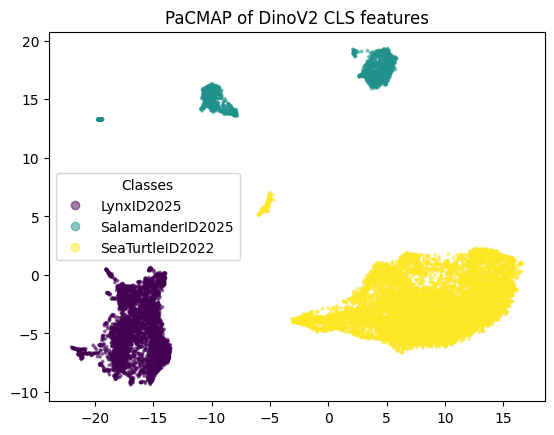

In [33]:
# map label to colors
from sklearn import preprocessing


def plot_emb(X, labels):
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    fig = plt.scatter(
        X[:, 0],
        X[:, 1],
        c=le.transform(labels),
        rasterized=True,
        s=3,
        alpha=0.5,
    )
    plt.legend(
        handles=fig.legend_elements()[0],
        labels=list(le.classes_),
        title="Classes",
    )


plt.title("PaCMAP of DinoV2 CLS features")
plot_emb(g_pm_cls, pdf.dataset)
plt.show()

In [34]:
X_avg_patch = np.stack(pdf.avg_patch.values)
display(X_avg_patch.shape)
g_pm_avg_patch = PaCMAP().fit_transform(X_avg_patch)

(15209, 768)

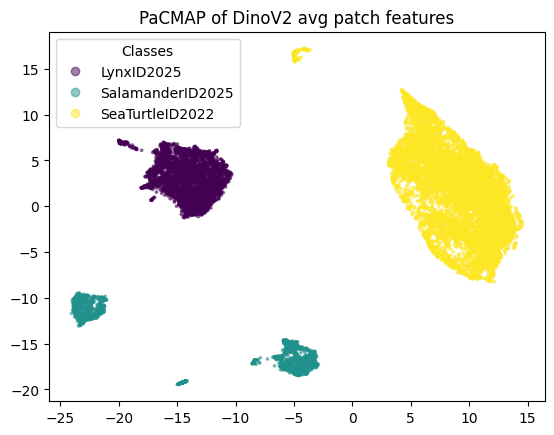

In [35]:
plt.title("PaCMAP of DinoV2 avg patch features")
plot_emb(g_pm_avg_patch, pdf.dataset)
plt.show()

In [75]:
from umap import UMAP

g_umap_cls = UMAP().fit_transform(X_cls)

/storage/home/hcoda1/8/amiyaguchi3/clef/animalclef-2025/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


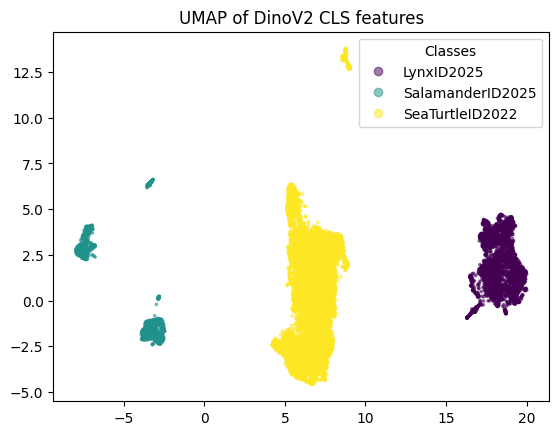

In [76]:
plt.title("UMAP of DinoV2 CLS features")
plot_emb(g_umap_cls, pdf.dataset)
plt.show()

How do we plot individuals? Well, one idea is to learn a 1d embedding that we can use to show that individuals form a gradient within a cluster. If there are a bunch of spots, then that means that it could be sorted better. We can transform this embedding from a float into an ordering.

In [37]:
@F.udf("array<float>")
def mean_embedding(embeddings):
    return np.mean(np.stack(embeddings), axis=0).tolist()


ids = (
    df.groupBy("identity")
    .agg(F.collect_list("token.cls").alias("embeddings"))
    .select(
        "identity",
        mean_embedding("embeddings").alias("embedding"),
    )
    .toPandas()
)
display(ids.head())

,identity,embedding
0,LynxID2025_lynx_04,"[1.9608027, -1.1126527, -2.3565633, -0.3056419..."
1,LynxID2025_lynx_08,"[1.7082918, -2.1121547, -1.5560057, -0.0668072..."
2,LynxID2025_lynx_16,"[0.9971921, -1.1349804, -1.7021044, 0.7312527,..."
3,LynxID2025_lynx_17,"[1.2295566, -2.260273, -1.8242552, 0.23571323,..."
4,LynxID2025_lynx_38,"[0.95234346, -1.3775812, -0.9651076, -0.572235..."


In [56]:
# now learn identity embedding on centroids
from umap import UMAP

X_id = np.stack(ids.embedding.values)
g_id_pm = PaCMAP(n_components=1).fit_transform(X_id)
g_id = UMAP(n_components=1).fit_transform(X_id)

Note: `n_components != 2` have not been thoroughly tested.


/storage/home/hcoda1/8/amiyaguchi3/clef/animalclef-2025/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/storage/home/hcoda1/8/amiyaguchi3/clef/animalclef-2025/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Note that we use UMAP because apparently PaCMAP isn't well defined for a single dimension.

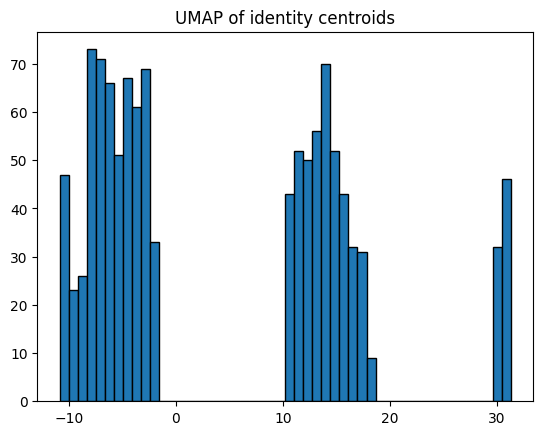

In [73]:
plt.hist(g_id, bins=50, edgecolor="black")
plt.title("UMAP of identity centroids")
plt.show()

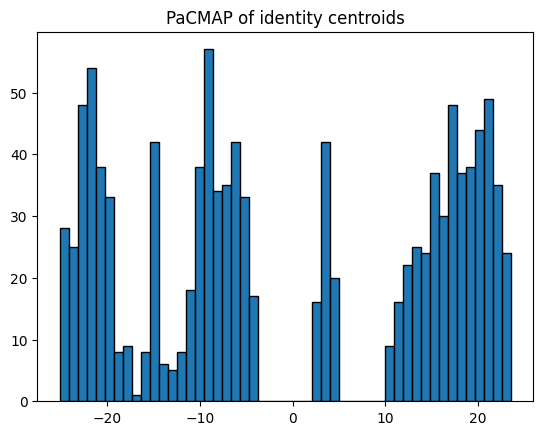

In [74]:
plt.hist(g_id_pm, bins=50, edgecolor="black")
plt.title("PaCMAP of identity centroids")
plt.show()

In [63]:
# add the column to the original df and then compute runlengths based on orderings
ids["umap_emb"] = g_id
ids["pmap_emb"] = g_id_pm
ids.head()

,identity,embedding,umap_emb,pmap_emb
0,LynxID2025_lynx_04,"[1.9608027, -1.1126527, -2.3565633, -0.3056419...",30.829639,3.214458
1,LynxID2025_lynx_08,"[1.7082918, -2.1121547, -1.5560057, -0.0668072...",29.869774,3.062227
2,LynxID2025_lynx_16,"[0.9971921, -1.1349804, -1.7021044, 0.7312527,...",30.250656,3.724348
3,LynxID2025_lynx_17,"[1.2295566, -2.260273, -1.8242552, 0.23571323,...",30.831217,3.196770
4,LynxID2025_lynx_38,"[0.95234346, -1.3775812, -0.9651076, -0.572235...",31.027143,3.951186


In [ ]:
# get a runlength of the identity by truncating the first part of the name
def calculate_runlength(names):
    # return tuples of name, length
    runlengths = []
    current_name = names[0]
    current_length = 1
    for name in names[1:]:
        if name == current_name:
            current_length += 1
        else:
            runlengths.append((current_name, current_length))
            current_name = name
            current_length = 1
    runlengths.append((current_name, current_length))
    return runlengths


names = ids.sort_values("umap_emb").reset_index().identity.values
names = [name.split("_")[0] for name in names if name is not None]
print("UMAP")
display(calculate_runlength(names))

print("PaCMAP")
names = ids.sort_values("pmap_emb").reset_index().identity.values
names = [name.split("_")[0] for name in names if name is not None]
display(calculate_runlength(names))

UMAP


[('SalamanderID2025', 587), ('SeaTurtleID2022', 438), ('LynxID2025', 77)]

PaCMAP


[('SalamanderID2025', 587), ('LynxID2025', 77), ('SeaTurtleID2022', 438)]

In [80]:
# and now let's plot 2d pacman
g_id_pm2d = PaCMAP(n_components=2).fit_transform(X_id)

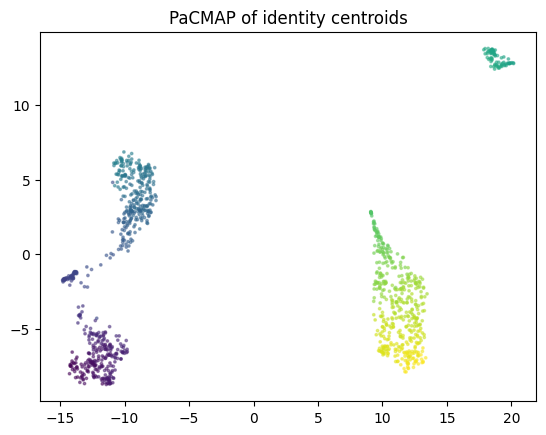

In [98]:
def plot_emb_float(X, c):
    plt.scatter(
        X[:, 0],
        X[:, 1],
        c=c,
        rasterized=True,
        s=3,
        alpha=0.5,
        # viridis?
        cmap="viridis",
    )


plt.title("PaCMAP of identity centroids")
plot_emb_float(g_id_pm2d, ids["pmap_emb"])
plt.show()

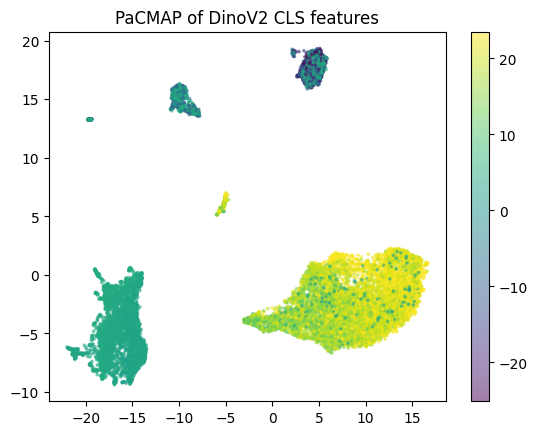

In [107]:
# and then one last plot, we get the original dataset and plot the color based on the identity
merged = pdf.merge(
    ids[["identity", "umap_emb", "pmap_emb"]],
    on="identity",
    how="left",
)
plt.title("PaCMAP of DinoV2 CLS features")
y = merged["pmap_emb"].values
# y = (y - y.min()) / (y.max() - y.min())
plot_emb_float(g_pm_cls, y)
plt.colorbar()
plt.show()

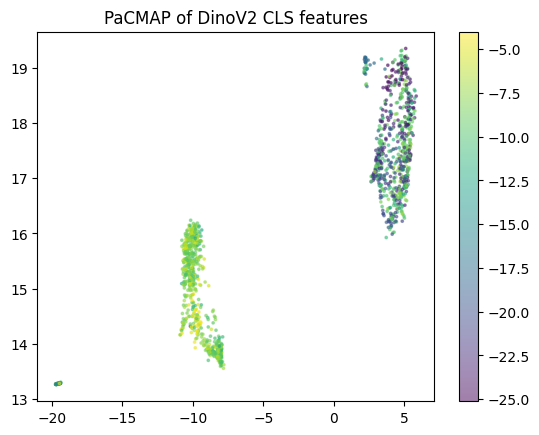

In [111]:
# now only look at the scatter of the salamanders

# get index of salamander index
where = (merged.dataset == "SalamanderID2025") & (~merged.identity.isnull())
# now get the subset of the data
plt.title("PaCMAP of DinoV2 CLS features")
y = merged[where]["pmap_emb"].values
plot_emb_float(g_pm_cls[where], y)
plt.colorbar()
plt.show()